# Clustering and Dimension Reduction

**Import Dependencies**

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**Load the dataset and skip the header row**

In [4]:
data = pd.read_csv("datasets/SouthGermanCredit.asc", sep=" ")
print(data.head())
print(data.info())

   laufkont  laufzeit  moral  verw  hoehe  sparkont  beszeit  rate  famges  \
0         1        18      4     2   1049         1        2     4       2   
1         1         9      4     0   2799         1        3     2       3   
2         2        12      2     9    841         2        4     2       2   
3         1        12      4     0   2122         1        3     3       3   
4         1        12      4     0   2171         1        3     4       3   

   buerge  ...  verm  alter  weitkred  wohn  bishkred  beruf  pers  telef  \
0       1  ...     2     21         3     1         1      3     2      1   
1       1  ...     1     36         3     1         2      3     1      1   
2       1  ...     1     23         3     1         1      2     2      1   
3       1  ...     1     39         3     1         2      2     1      1   
4       1  ...     2     38         1     2         2      2     2      1   

   gastarb  kredit  
0        2       1  
1        2       1  
2    

**Feature engineering**

In [5]:
data["total_assets"] = data["verm"] + data["sparkont"] + data["weitkred"]

**Extract features and target variable**

In [6]:
X = data.drop("kredit", axis=1)
y = data["kredit"]

**Scaling features**

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Splitting the dataset into training, validation, and test sets**

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

**Applying PCA for dimensionality reduction**

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)
X_pca_val = pca.transform(X_val)

**Applying NMF for dimensionality reduction**

In [10]:
min_value = X_train.min()  # Find the minimum value
X_non_negative = X_train - min_value
min_value_test = X_test.min()  
X_non_negative_test = X_test - min_value
min_value_val = X_val.min()  
X_non_negative_val = X_val - min_value

nmf = NMF(n_components=2, init='random', random_state=42)
# Fitting NMF model only on the training data
X_nmf = nmf.fit_transform(X_non_negative)

# Using the already fitted NMF model to transform test and validation data
X_nmf_test = nmf.transform(X_non_negative_test)
X_nmf_val = nmf.transform(X_non_negative_val)

**Plotting PCA and LDA projections**

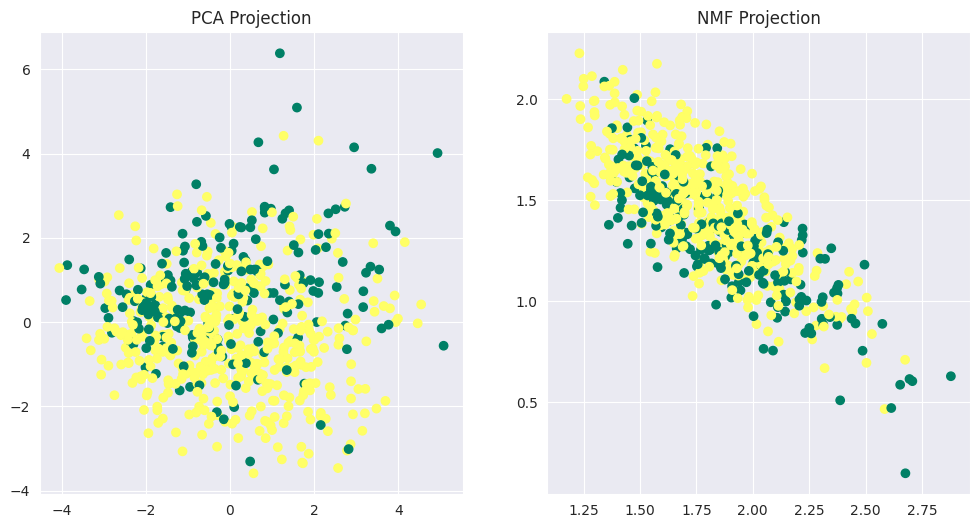

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap="summer")
plt.title("PCA Projection")

plt.subplot(1, 2, 2)
plt.scatter(X_nmf[:, 0], X_nmf[:, 1], c=y_train, cmap='summer', label='Data Points')
plt.title("NMF Projection")
plt.show()


**Clustering using KMeans**

In [12]:
def evaluate_kmeans(x, n_clusters):
    kmeans = KMeans(
        n_clusters=n_clusters, random_state=42, n_init=10
    )
    kmeans.fit(x)
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    return labels, inertia, kmeans

**Find the optimal number of clusters using elbow method**

Optimal number of clusters using PCA: 2
Optimal number of clusters using NMF: 2


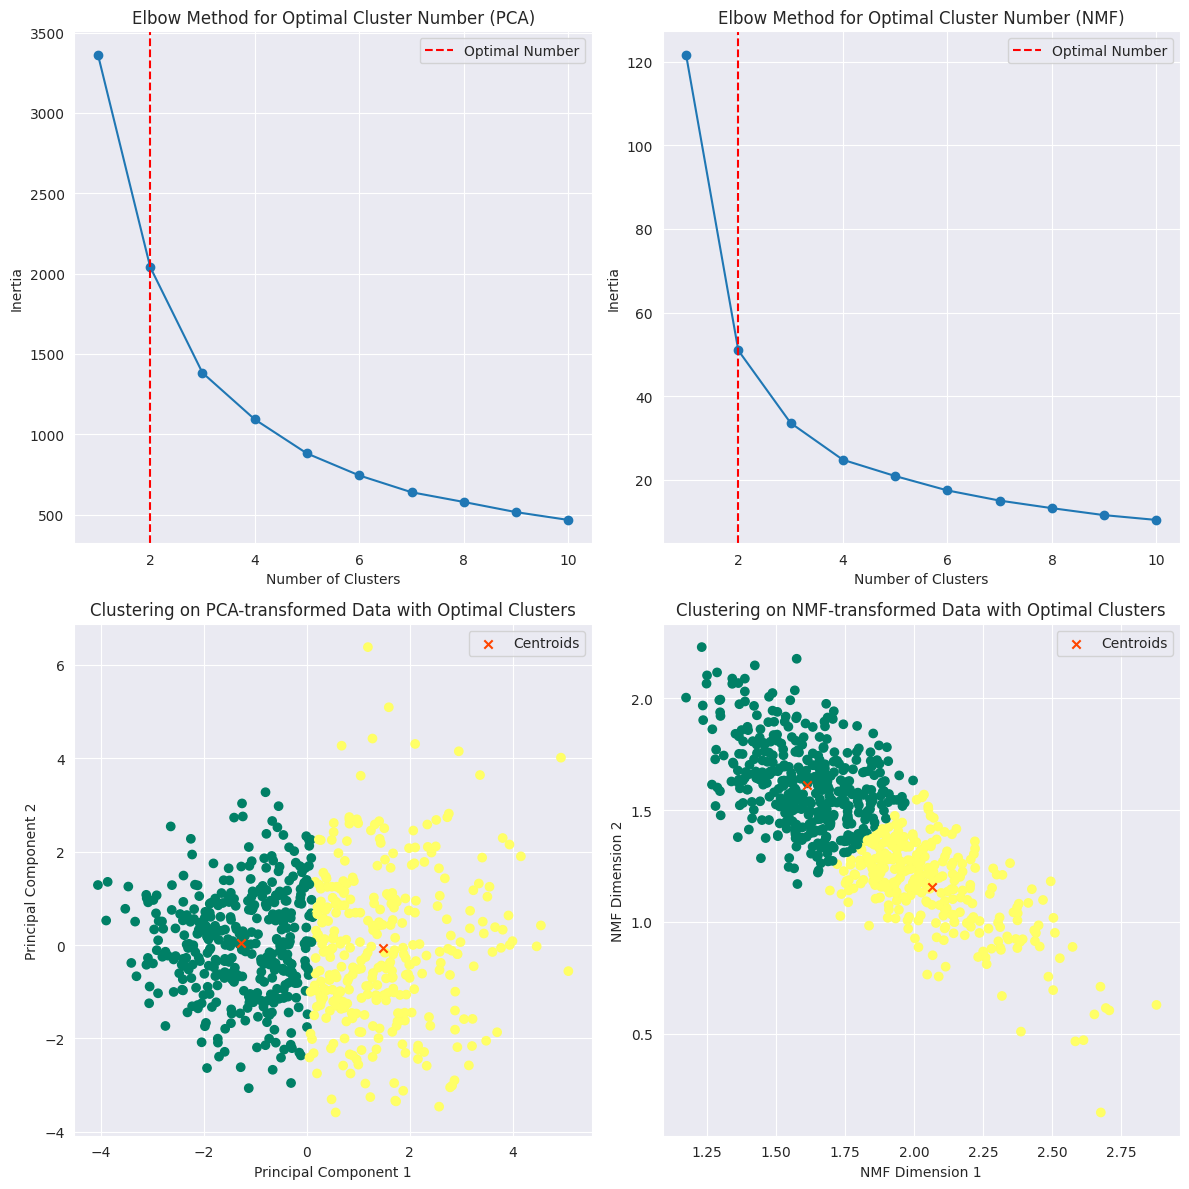

In [13]:
def elbow_values(dataset):
    inertia_values = []
    for i in range(1, 11):
        labels, inertia, kmeans = evaluate_kmeans(dataset, i)
        inertia_values.append(inertia)
    return inertia_values

def elbow_clusters_number(dataset):
    optimal_num_clusters = None
    inertia_vals = elbow_values(dataset)
    for i in range(1, len(inertia_vals) - 1):
        slope1 = inertia_vals[i] - inertia_vals[i - 1]
        slope2 = inertia_vals[i + 1] - inertia_vals[i]
        if slope1 / slope2 >= 1.5:
            optimal_num_clusters = i + 1
            break
    return optimal_num_clusters

print("Optimal number of clusters using PCA:", elbow_clusters_number(X_pca))
print("Optimal number of clusters using NMF:", elbow_clusters_number(X_nmf))

pca_clusters, _, kmeans_pca = evaluate_kmeans(X_pca, elbow_clusters_number(X_pca))
nmf_clusters, _, kmeans_nmf = evaluate_kmeans(X_nmf, elbow_clusters_number(X_nmf))

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot Inertia for PCA
axes[0, 0].plot(range(1, 11), elbow_values(X_pca), marker="o")
axes[0, 0].set_xlabel("Number of Clusters")
axes[0, 0].set_ylabel("Inertia")
axes[0, 0].set_title("Elbow Method for Optimal Cluster Number (PCA)")
axes[0, 0].axvline(x=elbow_clusters_number(X_pca), color='r', linestyle='--', label='Optimal Number')
axes[0, 0].legend()

# Plot Inertia for NMF
axes[0, 1].plot(range(1, 11), elbow_values(X_nmf), marker="o")
axes[0, 1].set_xlabel("Number of Clusters")
axes[0, 1].set_ylabel("Inertia")
axes[0, 1].set_title("Elbow Method for Optimal Cluster Number (NMF)")
axes[0, 1].axvline(x=elbow_clusters_number(X_nmf), color='r', linestyle='--', label='Optimal Number')
axes[0, 1].legend()

# Scatter plot of PCA-transformed data with cluster assignments
axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=pca_clusters, cmap='summer', marker='o')
scatter_centers_pca = axes[1, 0].scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], c='orangered', marker='x', label='Centroids')
axes[1, 0].set_title('Clustering on PCA-transformed Data with Optimal Clusters')
axes[1, 0].set_xlabel('Principal Component 1')
axes[1, 0].set_ylabel('Principal Component 2')
axes[1, 0].legend(handles=[scatter_centers_pca])

# Scatter plot of NMF-transformed data with cluster assignments
axes[1, 1].scatter(X_nmf[:, 0], X_nmf[:, 1], c=nmf_clusters, cmap='summer', marker='o')
scatter_centers_nmf = axes[1, 1].scatter(kmeans_nmf.cluster_centers_[:, 0], kmeans_nmf.cluster_centers_[:, 1], c='orangered', marker='x', label='Centroids')
axes[1, 1].set_title('Clustering on NMF-transformed Data with Optimal Clusters')
axes[1, 1].set_xlabel('NMF Dimension 1')
axes[1, 1].set_ylabel('NMF Dimension 2')
axes[1, 1].legend(handles=[scatter_centers_nmf])

plt.tight_layout()
plt.show()


**Find the optimal number of clusters using silhouette score**

Optimal number of clusters using PCA: 3
Optimal number of clusters using NMF: 2


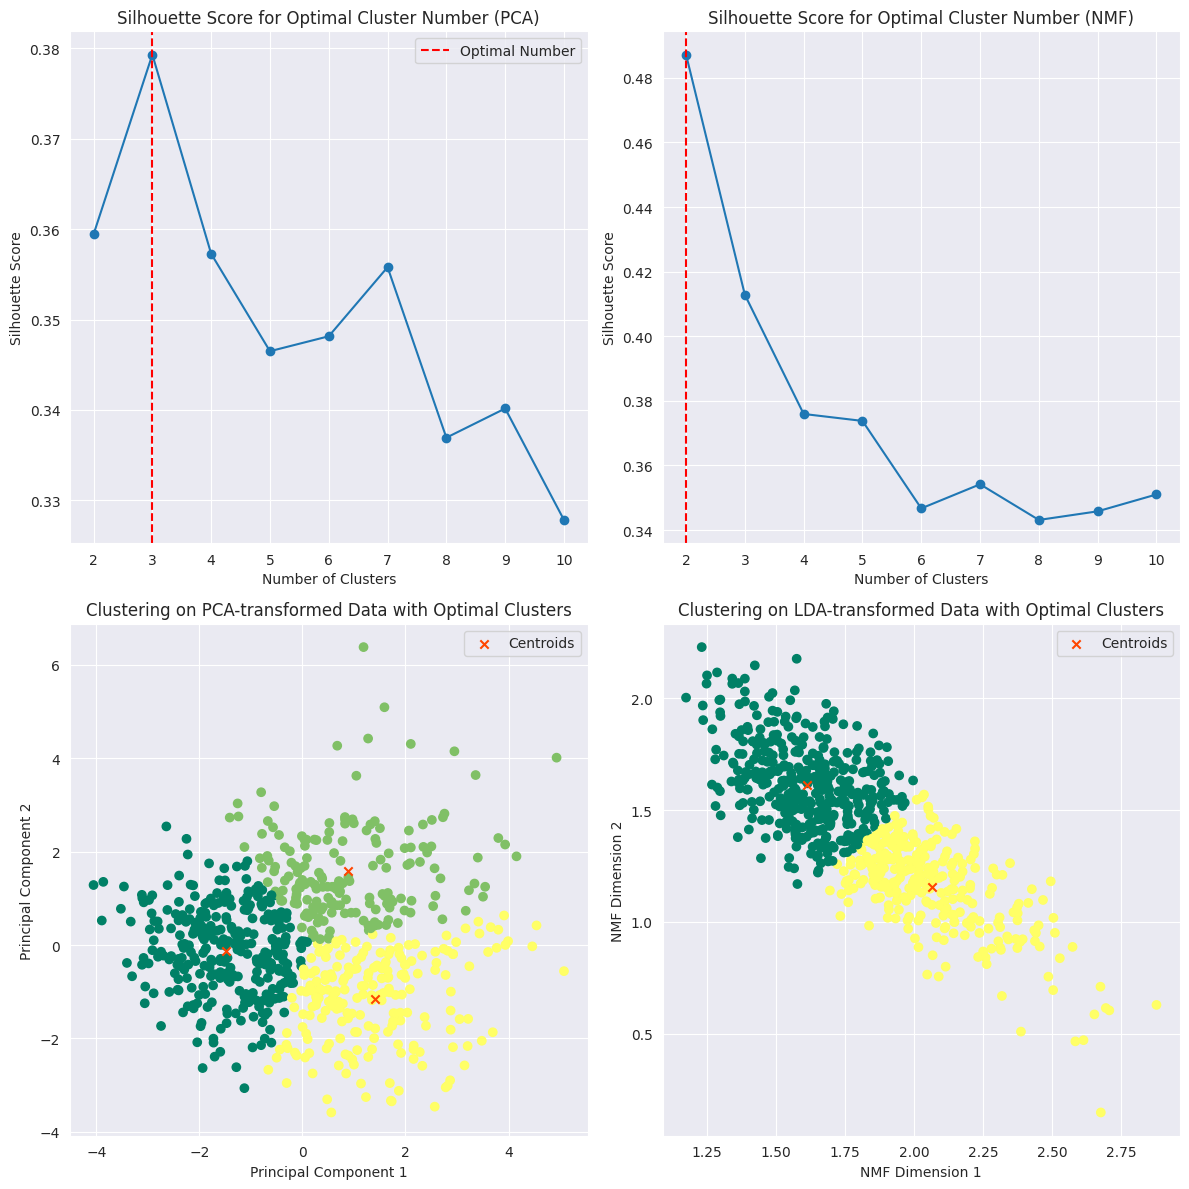

In [14]:
def silhouette(dataset):
    silhouette_scores = []
    for i in range(2, 11):
        labels = evaluate_kmeans(dataset, i)[0]
        score = silhouette_score(dataset, labels)
        silhouette_scores.append(score)
    return silhouette_scores

silhouette_clusters_pca = np.argmax(silhouette(X_pca)) + 2
silhouette_clusters_nmf = np.argmax(silhouette(X_nmf)) + 2
print("Optimal number of clusters using PCA:", silhouette_clusters_pca)
print("Optimal number of clusters using NMF:", silhouette_clusters_nmf)

pca_clusters, _, kmeans_pca = evaluate_kmeans(X_pca, silhouette_clusters_pca)
nmf_clusters, _, kmeans_nmf = evaluate_kmeans(X_nmf, silhouette_clusters_nmf)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot Silhouette Score for PCA
axes[0, 0].plot(range(2, 11), silhouette(X_pca), marker="o")
axes[0, 0].set_xlabel("Number of Clusters")
axes[0, 0].set_ylabel("Silhouette Score")
axes[0, 0].set_title("Silhouette Score for Optimal Cluster Number (PCA)")
axes[0, 0].axvline(x=silhouette_clusters_pca, color='r', linestyle='--', label='Optimal Number')
axes[0, 0].legend()

# Plot Silhouette Score for NMF
axes[0, 1].plot(range(2, 11), silhouette(X_nmf), marker="o")
axes[0, 1].set_xlabel("Number of Clusters")
axes[0, 1].set_ylabel("Silhouette Score")
axes[0, 1].set_title("Silhouette Score for Optimal Cluster Number (NMF)")
axes[0, 1].axvline(x=silhouette_clusters_nmf, color='r', linestyle='--', label='Optimal Number')
axes[0, 0].legend()

# Scatter plot of PCA-transformed data with cluster assignments
axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=pca_clusters, cmap='summer', marker='o')
scatter_centers_pca = axes[1, 0].scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], c='orangered', marker='x', label='Centroids')
axes[1, 0].set_title('Clustering on PCA-transformed Data with Optimal Clusters')
axes[1, 0].set_xlabel('Principal Component 1')
axes[1, 0].set_ylabel('Principal Component 2')
axes[1, 0].legend(handles=[scatter_centers_pca])

# Scatter plot of NMF-transformed data with cluster assignments
axes[1, 1].scatter(X_nmf[:, 0], X_nmf[:, 1], c=nmf_clusters, cmap='summer', marker='o')
scatter_centers_nmf = axes[1, 1].scatter(kmeans_nmf.cluster_centers_[:, 0], kmeans_nmf.cluster_centers_[:, 1], c='orangered', marker='x', label='Centroids')
axes[1, 1].set_title('Clustering on LDA-transformed Data with Optimal Clusters')
axes[1, 1].set_xlabel('NMF Dimension 1')
axes[1, 1].set_ylabel('NMF Dimension 2')
axes[1, 1].legend(handles=[scatter_centers_nmf])


# Adjust layout and show plots
plt.tight_layout()
plt.show()